In [ ]:
# This notebook requires a ~500 MB download from https://www.ebi.ac.uk/biostudies/files/S-BIAD1063/PTI-BIA/Anisotropic_target_small.zip

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift


import waveorder as wo
from waveorder import optics, waveorder_reconstructor, util, visual

import zarr

%matplotlib inline

## Initialization

### Experimental parameters

In [2]:
n_media       = 1.515                         # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532                         # illumination wavelength (um)
mag           = 63                            # magnification of the microscope                      
NA_obj        = 1.47                          # detection NA of the objective
NA_illu       = 1.4                           # illumination NA of the condenser
N_defocus     = 96                            # number of defocus images
N_channel     = 4                             # number of Polscope channels
N_pattern     = 9                             # number of illumination patterns
z_step        = 0.25                          # z_step of the stack
z_defocus     = (np.r_[:N_defocus]-0)*z_step  # z positions of the stack
ps            = 3.45*2/mag                    # effective pixel size at the sample plane (cam pix/mag in um)
cali          = False                         # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'global'                      # background correction method for Polscope recon (does not affect phase)
use_gpu       = False                         # option to use gpu or not (required cupy)
gpu_id        = 0                             # id of gpu to use

### Load sample images, background images, and calibration data

Calibrated source field:
[[ 0.7496+0.j    ]
 [-0.1284+0.6494j]]
Calibrated instrument matrix:
[[ 0.2478  0.2433  0.    ]
 [ 0.252   0.0013  0.2285]
 [ 0.2458 -0.2431 -0.0008]
 [ 0.2543 -0.0016 -0.2277]]


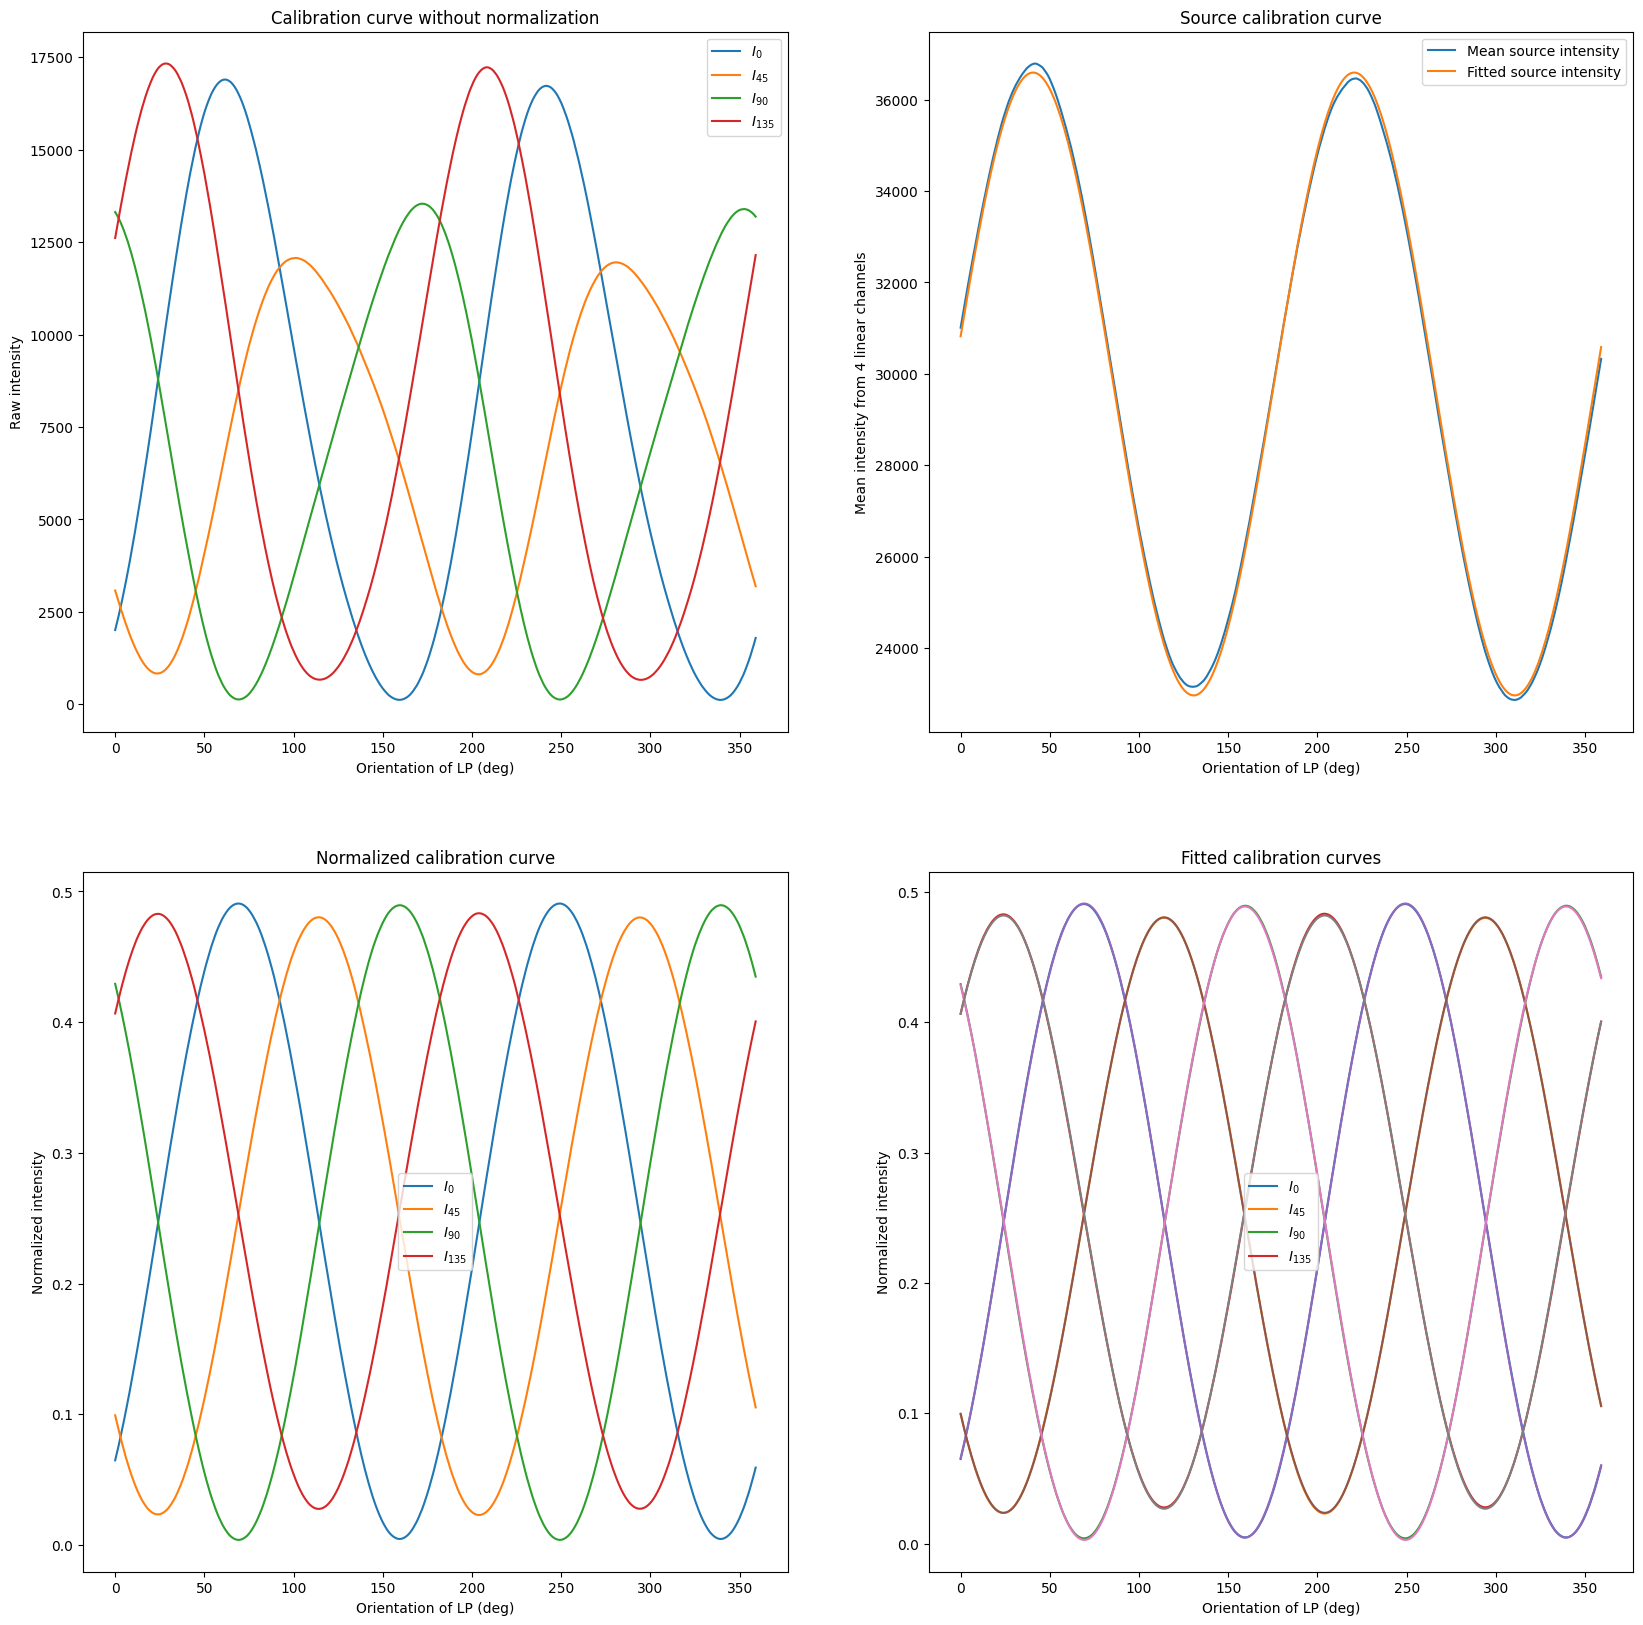

In [3]:
# Load data and bg
# Download data from 
PTI_file_name = '/path/to/Anisotropic_target_small/Anisotropic_target_small_raw.zarr'
reader = zarr.open(PTI_file_name, mode="r")
I_meas = np.transpose(np.array(reader["Row_0/Col_0/I_meas/array"]),(0,1,3,4,2))
I_bg = np.squeeze(np.transpose(np.array(reader["Row_0/Col_1/I_bg/array"]),(0,1,3,4,2)))

# Crop the data so that it fits in the GPU memory
I_meas = I_meas[:,:,50:250,50:250,:]
I_bg = I_bg[:,:,50:250,50:250]

# Load calibration

PTI_file = zarr.open(PTI_file_name, mode="r")
I_cali_mean = np.array(PTI_file.I_cali_mean)


# source polarization, instrument matrix calibration
E_in, A_matrix, I_cali_mean = wo.waveorder_reconstructor.instrument_matrix_and_source_calibration(I_cali_mean, handedness = 'RCP')


### Initiate the reconstruction

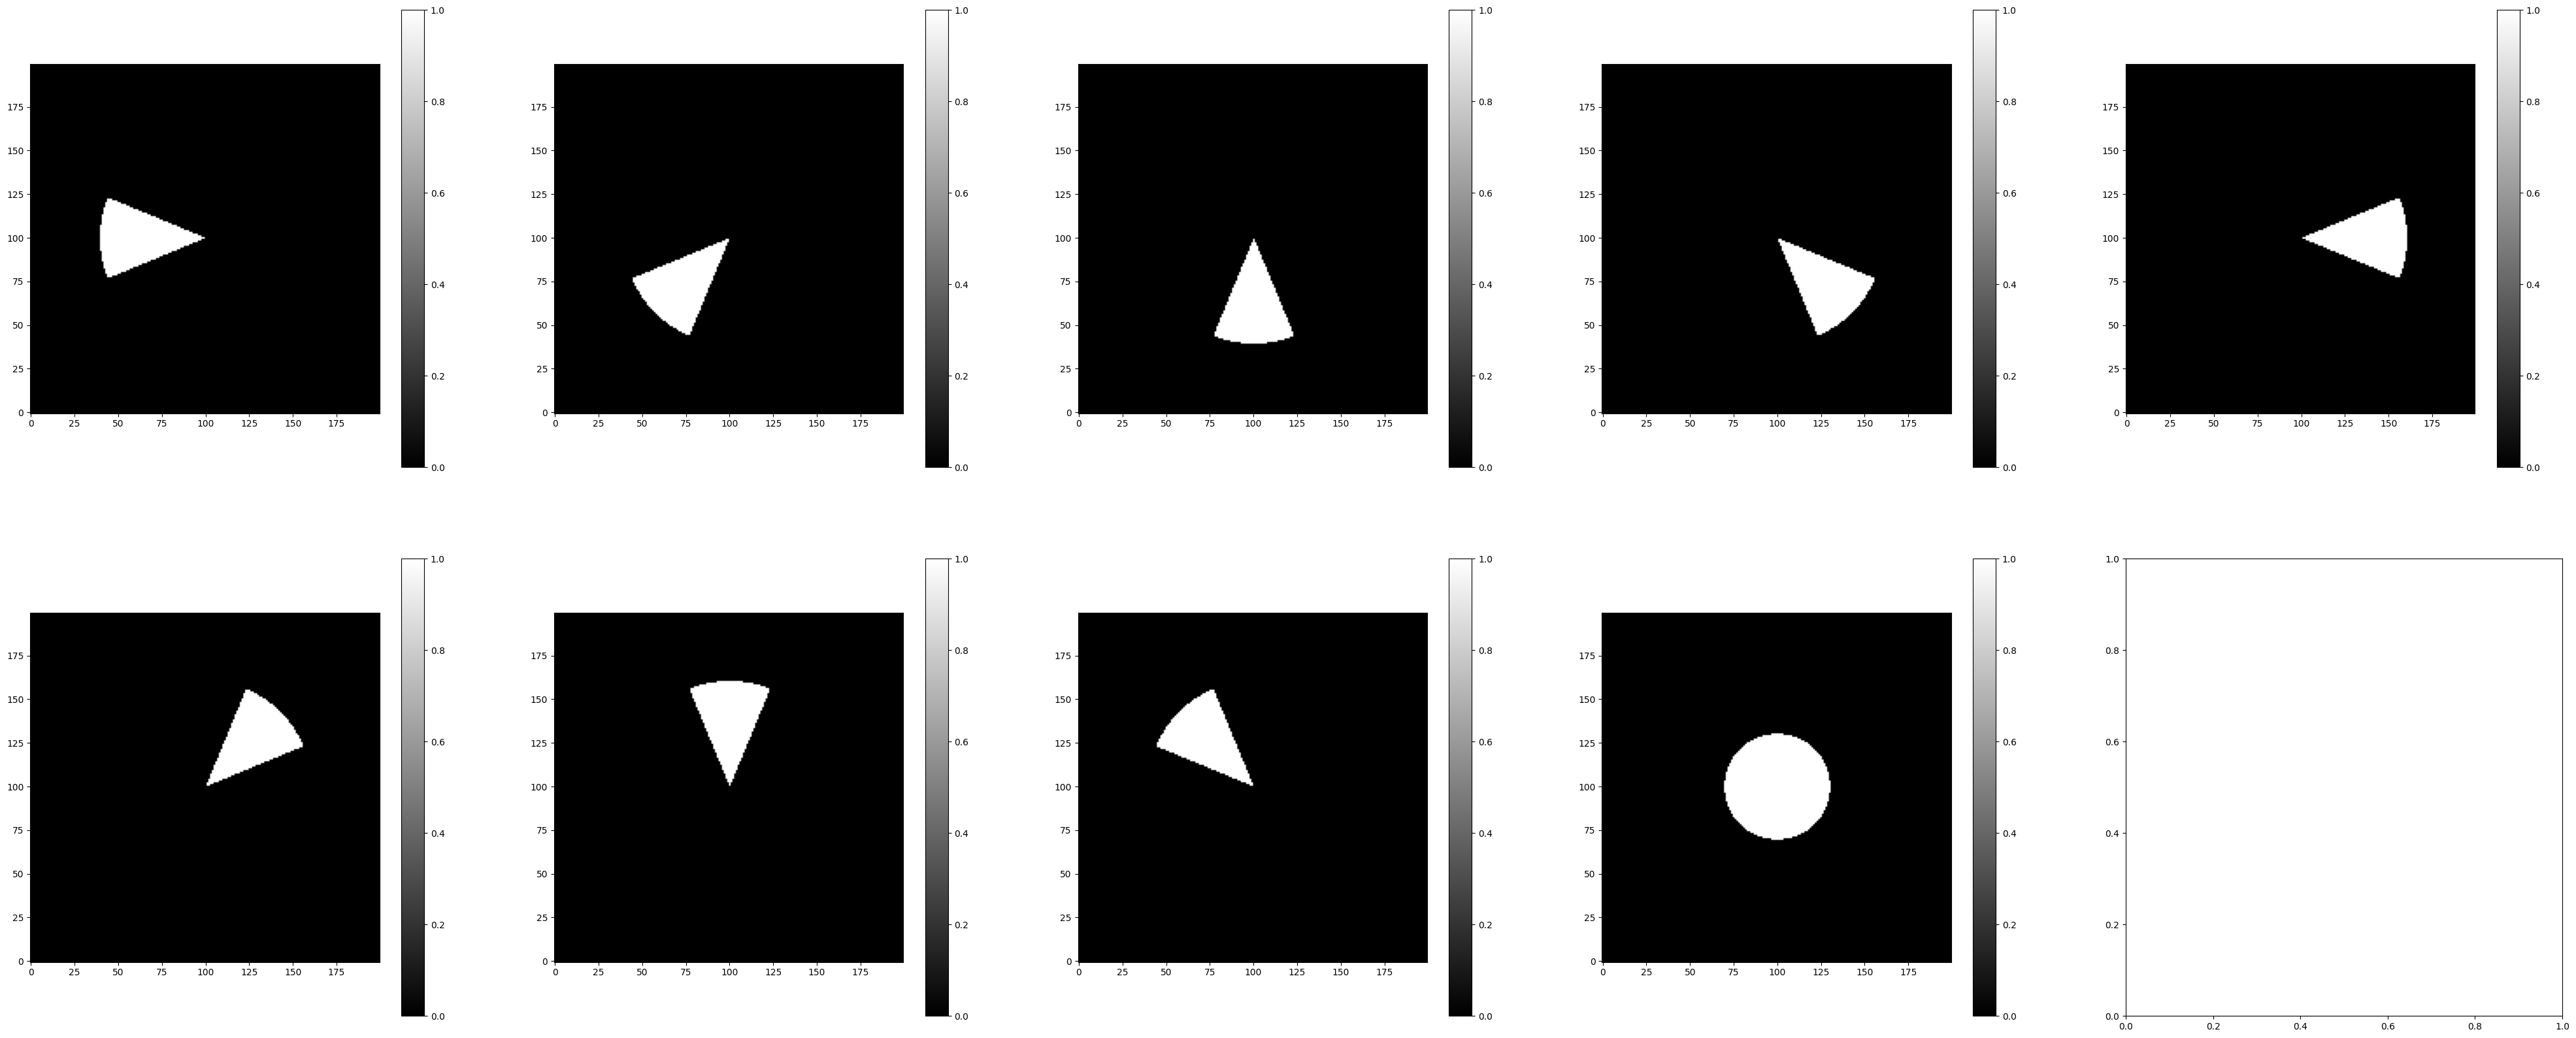

In [4]:
# setup illumination patterns

_,_,Ns,Ms,_ = I_meas.shape

xx, yy, fxx, fyy = util.gen_coordinate((Ns, Ms), ps)
frr = np.sqrt(fxx**2 + fyy**2)

rotation_angle=[180-22.5, 225-22.5, 270-22.5, 315-22.5, 0-22.5, 45-22.5, 90-22.5, 135-22.5]
sector_angle = 45

Source_BF = np.array(optics.generate_pupil(frr, NA_obj/n_media/2, lambda_illu/n_media))
Source = optics.gen_sector_Pupil(fxx, fyy, NA_obj/n_media, lambda_illu/n_media, sector_angle, rotation_angle)
Source.append(Source_BF)
Source = np.array(Source)
    
# setup polarization state of the illumination
Source_PolState = np.zeros((len(Source),2), complex)

for i in range(len(Source)):
    Source_PolState[i,0] = E_in[0]
    Source_PolState[i,1] = E_in[1]
    
    
visual.plot_multicolumn(fftshift(Source,axes=(1,2)), origin='lower', num_col=5)

In [6]:
# Initiate reconstruction with experimental parameters

setup = waveorder_reconstructor.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, \
                                n_media=n_media, cali=cali, bg_option=bg_option, \
                                A_matrix = A_matrix, \
                                phase_deconv=None, inc_recon='3D', \
                                illu_mode='Arbitrary', Source = Source, \
                                Source_PolState=Source_PolState, \
                                use_gpu=use_gpu, gpu_id=gpu_id)

/Users/talon.chandler/waveorder/waveorder/optics.py:321: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(z_position_list)[:, None, None]
/Users/talon.chandler/waveorder/waveorder/optics.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(z_position_list)[:, None, None]


## Compute Stokes volumes and visualize intensity & stokes volumes.


In [8]:

# convert intensity to Stokes parameters
S_image_recon = setup.Stokes_recon(I_meas[:,:,:,:,::-1])
S_bg_recon = setup.Stokes_recon(I_bg[:,:,:,:])

# background correction to all the Stokes parameter
S_image_tm = np.zeros_like(S_image_recon)
S_image_tm[0] = S_image_recon[0]/S_bg_recon[0,:,:,:,np.newaxis]-1
S_image_tm[1] = S_image_recon[1]/S_bg_recon[0,:,:,:,np.newaxis] - S_bg_recon[1,:,:,:,np.newaxis]*S_image_recon[0]/S_bg_recon[0,:,:,:,np.newaxis]**2
S_image_tm[2] = S_image_recon[2]/S_bg_recon[0,:,:,:,np.newaxis] - S_bg_recon[2,:,:,:,np.newaxis]*S_image_recon[0]/S_bg_recon[0,:,:,:,np.newaxis]**2



In [10]:
# browse raw intensity stacks (stack_idx_1: z index, stack_idx2: pattern index)
visual.parallel_5D_viewer(np.transpose(I_meas[:,:,:,:,::-1],(4,1,0,2,3)), num_col=4, size=10, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=95), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [12]:
# browse uncorrected Stokes parameters (stack_idx_1: z index, stack_idx2: pattern index)
visual.parallel_5D_viewer(np.transpose(S_image_recon,(4,1,0,2,3)), num_col=3, size=8,  set_title=True, origin='lower',  titles=[r'$S_0$', r'$S_1$', r'$S_2$'])

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=95), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [13]:
# browse corrected Stokes parameters (stack_idx_1: z index, stack_idx2: pattern index)
visual.parallel_5D_viewer(np.transpose(S_image_tm,(4,1,0,2,3)), num_col=3, size=8, origin='lower',  titles=[r'$S_0$', r'$S_1$', r'$S_2$'],  set_title=True)

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=95), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

## 3D uPTI reconstruction

### 3D volumes of the components of scattering potential tensor

In [14]:
# regularization on each component of the scattering potential tensor
# in the order of [0r, 0i, 1c, 1s, 2c, 2s, 3]
# It is good to set the regularization such that (1c, 1s), (2c, 2s) have the same regularization
reg_inc = np.array([2.5, 5, 1, 1, 3, 3, 3])*1

# regulairzation for estimating principal retardance
reg_ret_pr = 1e-2

# reconstruct components of scattering potential tensor
f_tensor = setup.scattering_potential_tensor_recon_3D_vec(S_image_tm, reg_inc=reg_inc, cupy_det=True)

Finished preprocess, elapsed time: 50.08
Finished reconstruction, elapsed time: 186.49


In [16]:
# browse the z-stack of components of scattering potential tensor
visual.parallel_4D_viewer(np.transpose(f_tensor,(3,0,1,2)), num_col=4, origin='lower', size=8, titles=[r'$f_{0r}$', r'$f_{0i}$', r'$f_{1c}$',r'$f_{1s}$',\
                                              r'$f_{2c}$', r'$f_{2s}$', r'$f_{3}$'], set_title=True)

interactive(children=(IntSlider(value=0, description='stack_idx', max=95), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

|  20  |  4.80e+11  |   1578.54   |
Finish optic sign estimation, elapsed time: 1579.38


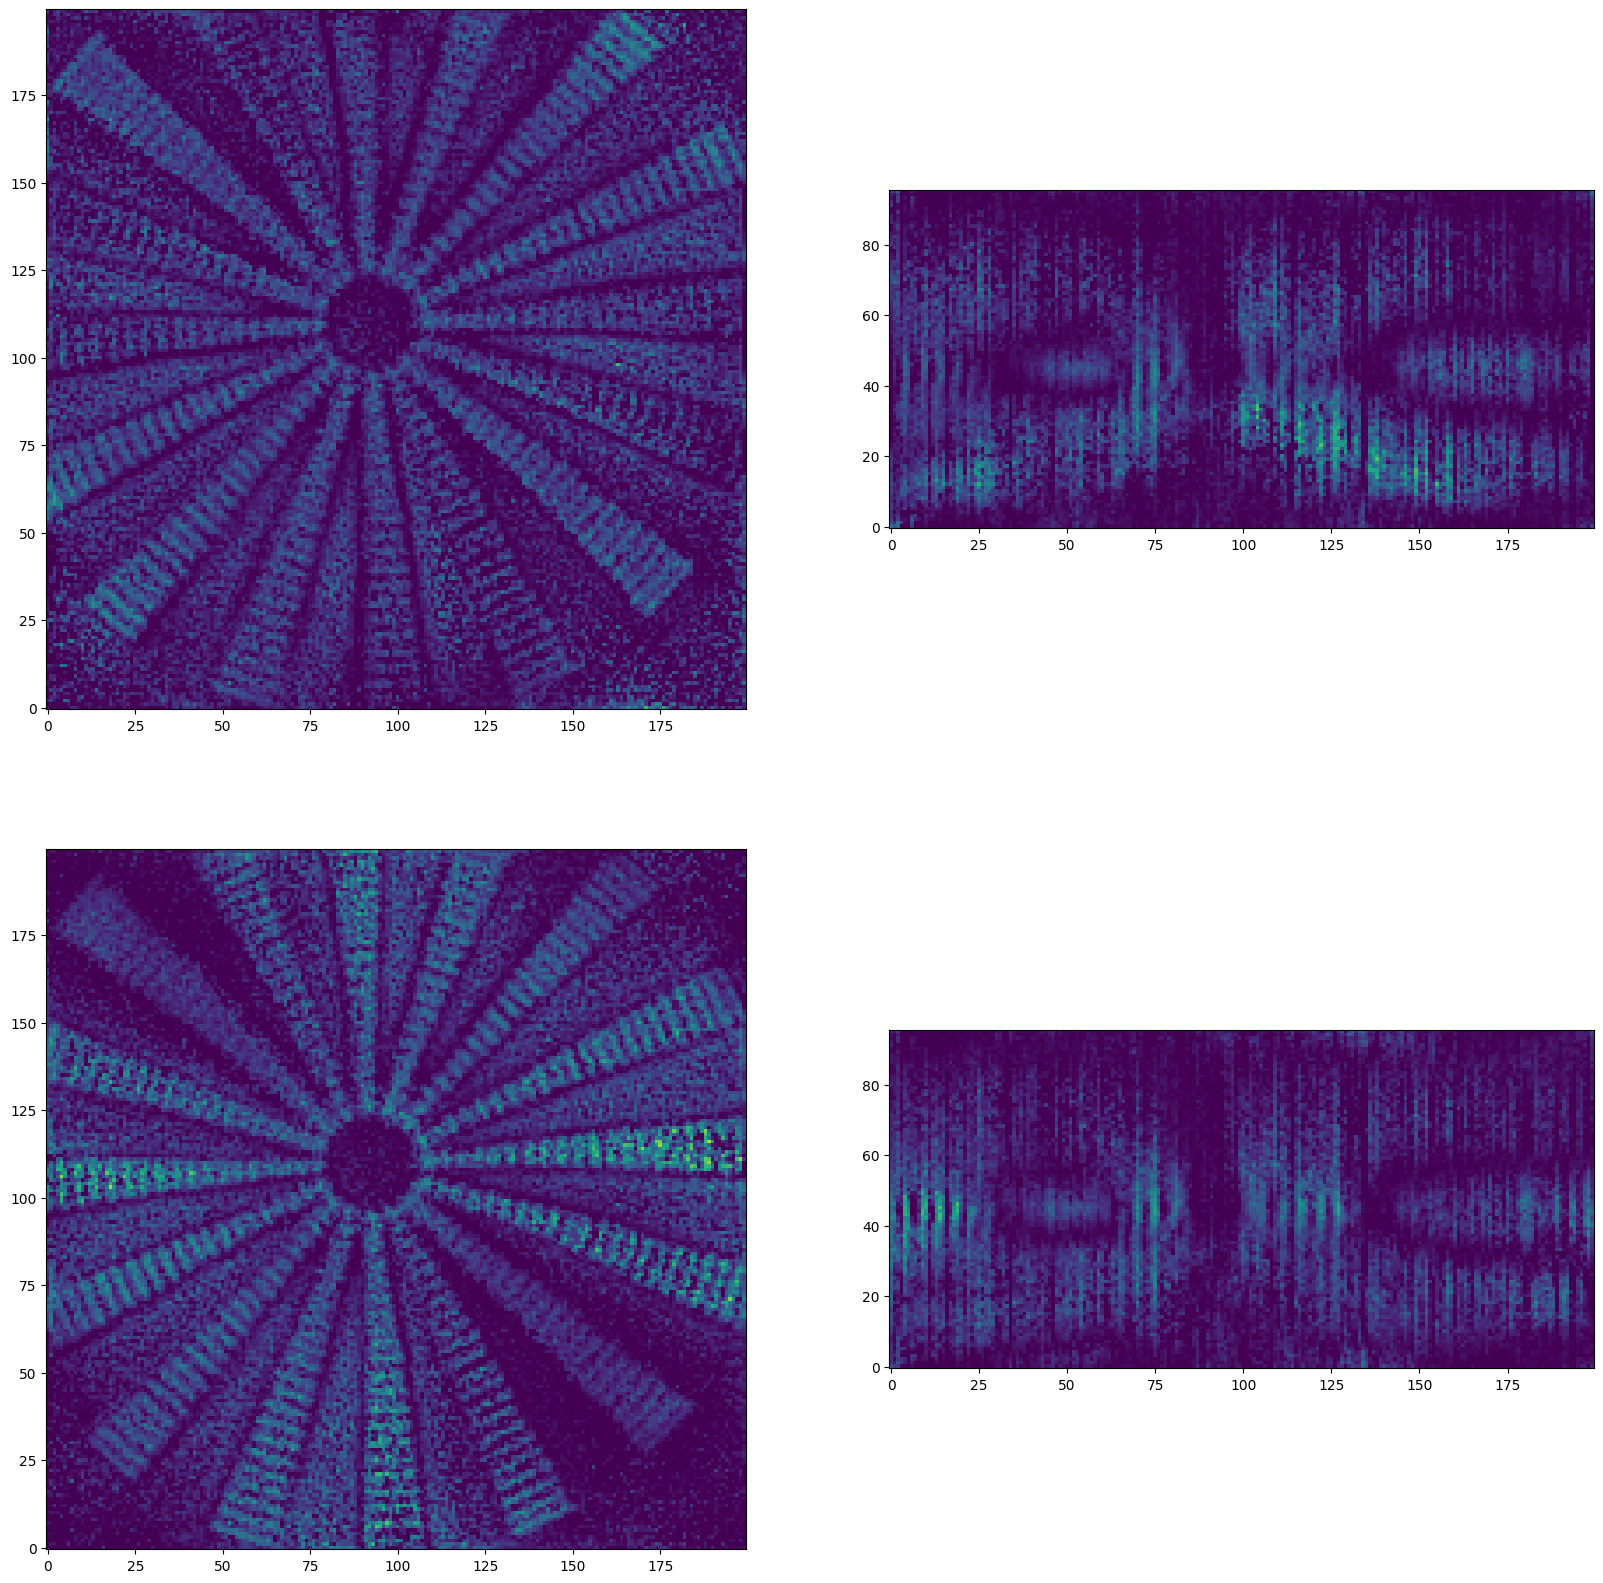

In [17]:
# reconstruct 3D anisotropy (principal retardance, 3D orientation, optic sign probability)
# material type: 
# "positive" -> only solution of positively uniaxial material
# "negative" -> only solution of negatively uniaxial meterial
# "unknown" -> both solutions of positively and negatively uniaxial material + optic sign estimation

retardance_pr, azimuth, theta, mat_map = setup.scattering_potential_tensor_to_3D_orientation(f_tensor, S_image_tm,\
                                                                                             material_type='unknown', reg_ret_pr = reg_ret_pr, itr=20, fast_gpu_mode=True)

In [20]:
p_mat_map = optics.optic_sign_probability(mat_map, mat_map_thres=0.2)
phase = optics.phase_inc_correction(f_tensor[0], retardance_pr[1], theta[1])
phase_PT, absorption_PT, retardance_pr_PT = [optics.unit_conversion_from_scattering_potential_to_permittivity(SP_array, lambda_illu, n_media=n_media, imaging_mode = '3D') 
                                             for SP_array in [phase, f_tensor[1].copy(), retardance_pr]]
retardance_pr_PT = np.array([((-1)**i)*util.wavelet_softThreshold(((-1)**i)*retardance_pr_PT[i], 'db8', 0.00303, level=1) for i in range(2)])



## Visualize reconstructed physical properties of the anisotropic glass target


### Reconstructed phase, absorption, principal retardance, azimuth, and inclination assuming (+) and (-) optic sign

In [21]:
# browse the reconstructed physical properties
visual.parallel_4D_viewer(np.transpose(np.stack([phase_PT, retardance_pr_PT[0], azimuth[0], theta[0], \
                                             absorption_PT, retardance_pr_PT[1], azimuth[1], theta[1]]),(3,0,1,2)), num_col=4, origin='lower', \
                      set_title=True, titles=[r'phase',r'principal retardance (+)', r'$\omega$ (+)', r'$\theta$ (+)',\
                                              r'absorption',r'principal retardance (-)', r'$\omega$ (-)', r'$\theta$ (-)'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=95), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [ ]:
# (Obsolete, not maintained) save results to zarr array

#writer = WaveorderWriter('.', hcs=False, hcs_meta=None, verbose=True)
#writer.create_zarr_root('Anisotropic_target_small_processed.zarr')
#chan_names = ['f_tensor0r', 'f_tensor0i', 'f_tensor1c','f_tensor1s','f_tensor2c','f_tensor2s', 'f_tensor3', 'mat_map0', 'mat_map1']
#PTI_array = np.transpose(np.concatenate((f_tensor, mat_map),axis=0)[np.newaxis,...],(0,1,4,2,3)) # dimension (T, C, Z, Y, X)
#data_shape = PTI_array.shape
#chunk_size = (1,1,1)+PTI_array.shape[3:]
#writer.init_array(0, data_shape, chunk_size, chan_names, position_name='f_tensor', overwrite=True)
#writer.write(PTI_array, p=0)

#chan_names_phys = ['Phase3D', 'Retardance3D', 'Orientation', 'Inclination', 'Optic_sign']
#phys_data_array = np.transpose(np.array([phase_PT, np.abs(retardance_pr_PT[1]), azimuth[1], theta[1], p_mat_map]),(0,3,1,2))[np.newaxis,...]
#data_shape_phys = phys_data_array.shape
#dtype = 'float32'
#writer.init_array(1, data_shape_phys, chunk_size, chan_names_phys, dtype, position_name='Stitched_physical', overwrite=True)
#writer.write(phys_data_array, p=1)

In [34]:
# Load the processed results
PTI_file_name = '/path/to/Anisotropic_target_small/Anisotropic_target_small_processed.zarr'
reader = zarr.open(PTI_file_name, mode="r")
PTI_array = np.array(reader["Row_0/Col_0/f_tensor/array"])
print(PTI_array.shape)
PTI_array = np.transpose(PTI_array, (0,1,3,4,2))[0]
f_tensor = PTI_array[:7]
mat_map = PTI_array[7:]

# compute the physical properties from the scattering potential tensor

retardance_pr_p, azimuth_p, theta_p = optics.scattering_potential_tensor_to_3D_orientation_PN(f_tensor, material_type='positive', reg_ret_pr = reg_ret_pr)
retardance_pr_n, azimuth_n, theta_n = optics.scattering_potential_tensor_to_3D_orientation_PN(f_tensor, material_type='negative', reg_ret_pr = reg_ret_pr)
retardance_pr = np.array([retardance_pr_p,retardance_pr_n])
azimuth = np.array([azimuth_p,azimuth_n])
theta = np.array([theta_p, theta_n])

p_mat_map = optics.optic_sign_probability(mat_map, mat_map_thres=0.09)
phase = optics.phase_inc_correction(f_tensor[0], retardance_pr[1], theta[1])
phase_PT, absorption_PT, retardance_pr_PT = [optics.unit_conversion_from_scattering_potential_to_permittivity(SP_array, lambda_illu, n_media=n_media, imaging_mode = '3D') 
                                             for SP_array in [phase, f_tensor[1].copy(), retardance_pr]]
retardance_pr_PT = np.array([((-1)**i)*util.wavelet_softThreshold(((-1)**i)*retardance_pr_PT[i], 'db8', 0.00303, level=1) for i in range(2)])



(1, 9, 96, 200, 200)


### Phase, principal retardance, azimuth, inclination, and optic signtruction

Text(0.5, 1.0, 'inclination (+) (xz)')

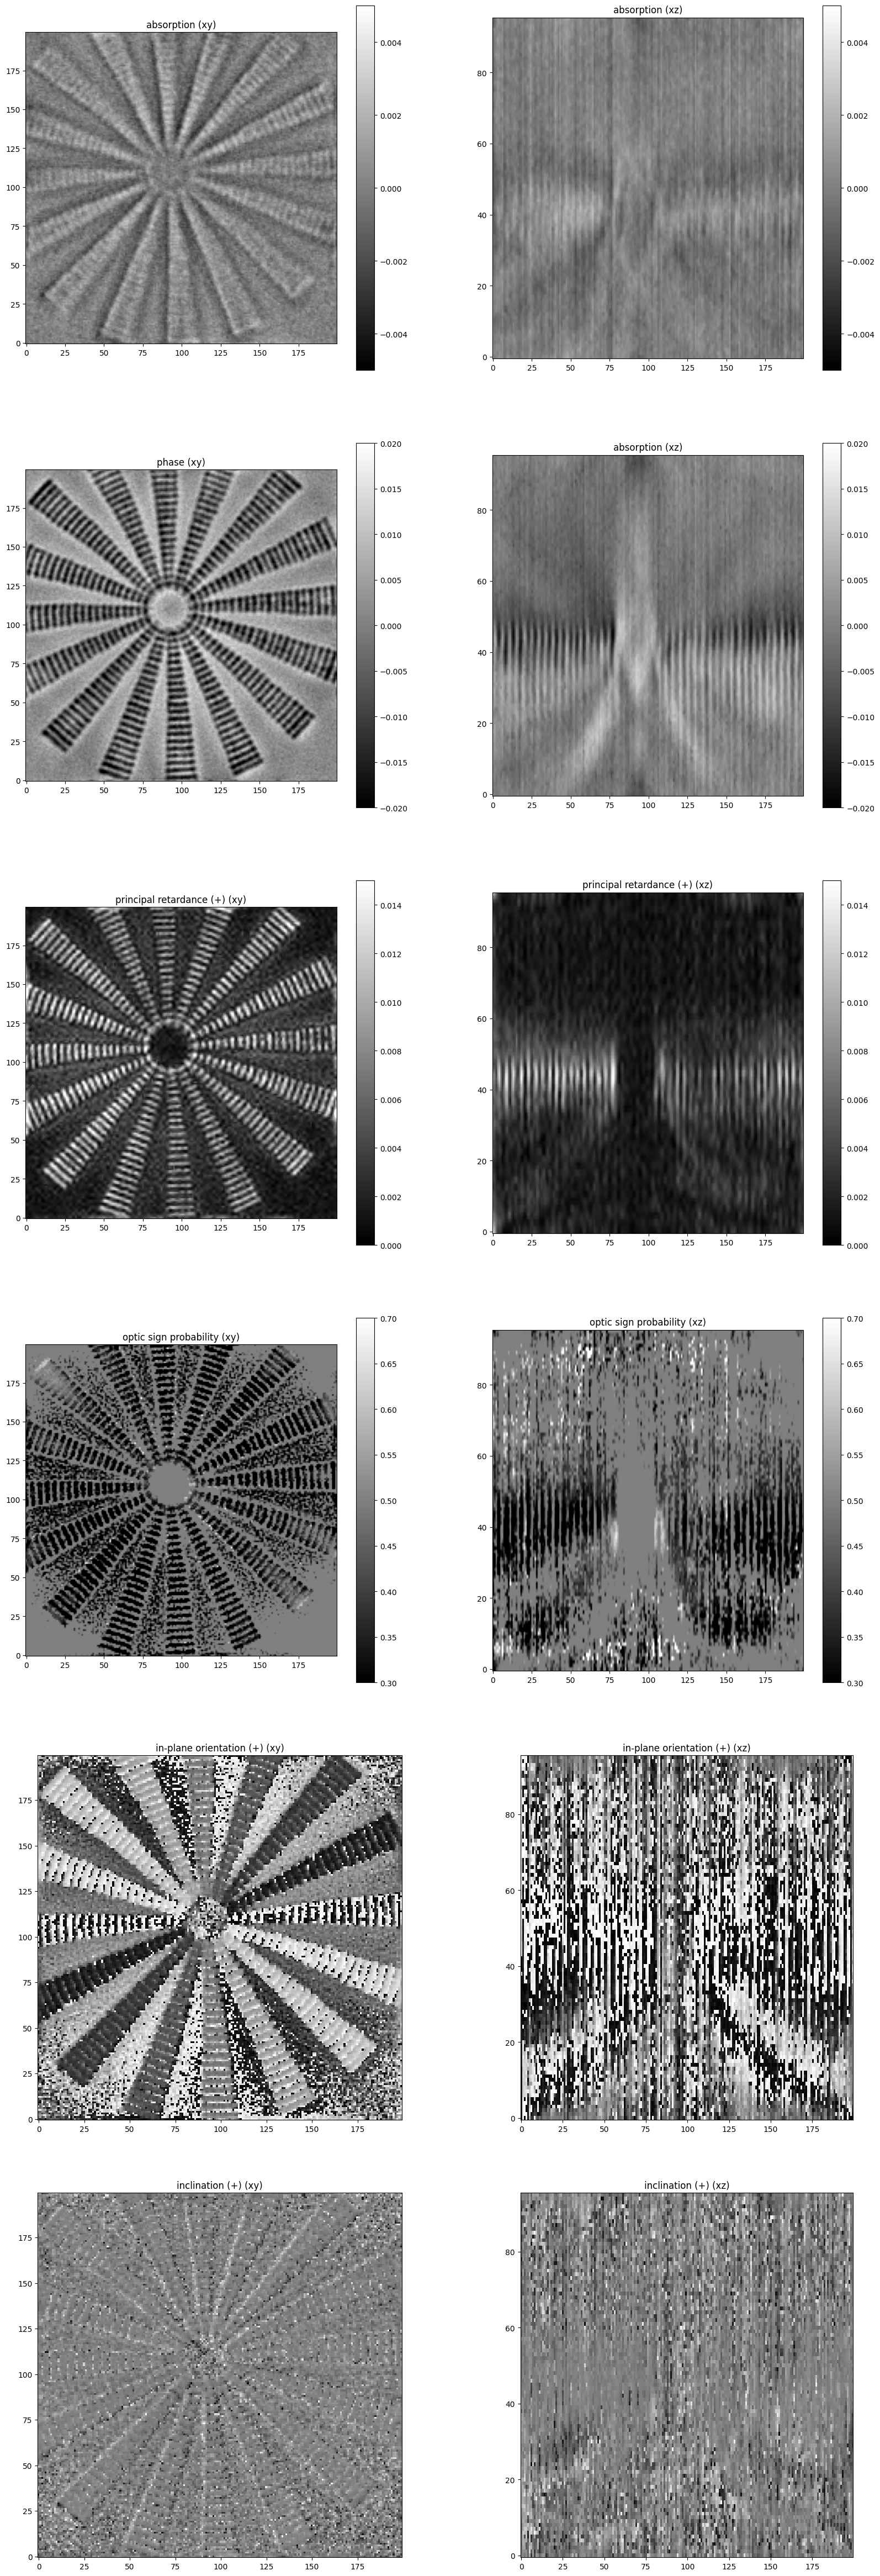

In [35]:
z_layer = 44
y_layer = 109
phase_min = -0.02
phase_max = 0.02
abs_min = -0.005
abs_max = 0.005
ret_min = 0
ret_max = 0.015
p_min   = 0.3
p_max   = 0.7


fig,ax = plt.subplots(6,2,figsize=(20,60))
sub_ax = ax[0,0].imshow(absorption_PT[:,:,z_layer], cmap='gray', origin='lower', vmin=abs_min, vmax=abs_max)
ax[0,0].set_title('absorption (xy)')
plt.colorbar(sub_ax, ax=ax[0,0])

sub_ax = ax[0,1].imshow(np.transpose(absorption_PT[y_layer,:,:]), cmap='gray', origin='lower',vmin=abs_min, vmax=abs_max,aspect=z_step/ps)
ax[0,1].set_title('absorption (xz)')
plt.colorbar(sub_ax, ax=ax[0,1])

sub_ax = ax[1,0].imshow(phase_PT[:,:,z_layer], cmap='gray', origin='lower', vmin=phase_min, vmax=phase_max)
ax[1,0].set_title('phase (xy)')
plt.colorbar(sub_ax, ax=ax[1,0])

sub_ax = ax[1,1].imshow(np.transpose(phase_PT[y_layer,:,:]), cmap='gray', origin='lower',vmin=phase_min, vmax=phase_max,aspect=z_step/ps)
ax[1,1].set_title('absorption (xz)')
plt.colorbar(sub_ax, ax=ax[1,1])

sub_ax = ax[2,0].imshow(np.abs(retardance_pr_PT[0,:,:,z_layer]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max)
ax[2,0].set_title('principal retardance (+) (xy)')
plt.colorbar(sub_ax, ax=ax[2,0])

sub_ax = ax[2,1].imshow(np.transpose(np.abs(retardance_pr_PT[0,y_layer,:,:])), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max,aspect=z_step/ps)
ax[2,1].set_title('principal retardance (+) (xz)')
plt.colorbar(sub_ax, ax=ax[2,1])

sub_ax = ax[3,0].imshow(np.abs(p_mat_map[:,:,z_layer]), cmap='gray', origin='lower',vmin=p_min, vmax=p_max)
ax[3,0].set_title('optic sign probability (xy)')
plt.colorbar(sub_ax, ax=ax[3,0])

sub_ax = ax[3,1].imshow(np.transpose(np.abs(p_mat_map[y_layer,:,:])), cmap='gray', origin='lower',vmin=p_min, vmax=p_max, aspect=z_step/ps)
ax[3,1].set_title('optic sign probability (xz)')
plt.colorbar(sub_ax, ax=ax[3,1])

sub_ax = ax[4,0].imshow(azimuth[0,:,:,z_layer], cmap='gray', origin='lower',vmin=0, vmax=np.pi)
ax[4,0].set_title('in-plane orientation (+) (xy)')

sub_ax = ax[4,1].imshow(np.transpose(azimuth[0,y_layer,:,:]), cmap='gray', origin='lower', vmin=0, vmax=np.pi, aspect=z_step/ps)
ax[4,1].set_title('in-plane orientation (+) (xz)')

sub_ax = ax[5,0].imshow(theta[0,:,:,z_layer], cmap='gray', origin='lower',vmin=0, vmax=np.pi)
ax[5,0].set_title('inclination (+) (xy)')

sub_ax = ax[5,1].imshow(np.transpose(theta[0,y_layer,:,:]), cmap='gray', origin='lower', vmin=0, vmax=np.pi, aspect=z_step/ps)
ax[5,1].set_title('inclination (+) (xz)')


In [36]:
# browse XY planes of the phase and principal retardance
visual.parallel_4D_viewer(np.transpose([np.clip(phase_PT, phase_min, phase_max), np.clip(np.abs(retardance_pr_PT[1]), ret_min, ret_max)],(3,0,1,2)), origin='lower', size=20)

interactive(children=(IntSlider(value=0, description='stack_idx', max=95), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### Render 3D orientation with 3D colorsphere (azimuth and inclination)

In [37]:
# create color-coded orientation images

ret_min_color = 0
ret_max_color = 0.012

orientation_3D_image = np.transpose(np.array([azimuth[1]/2/np.pi, theta[1], (np.clip(np.abs(retardance_pr_PT[1]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]),(3,1,2,0))
orientation_3D_image_RGB = visual.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)


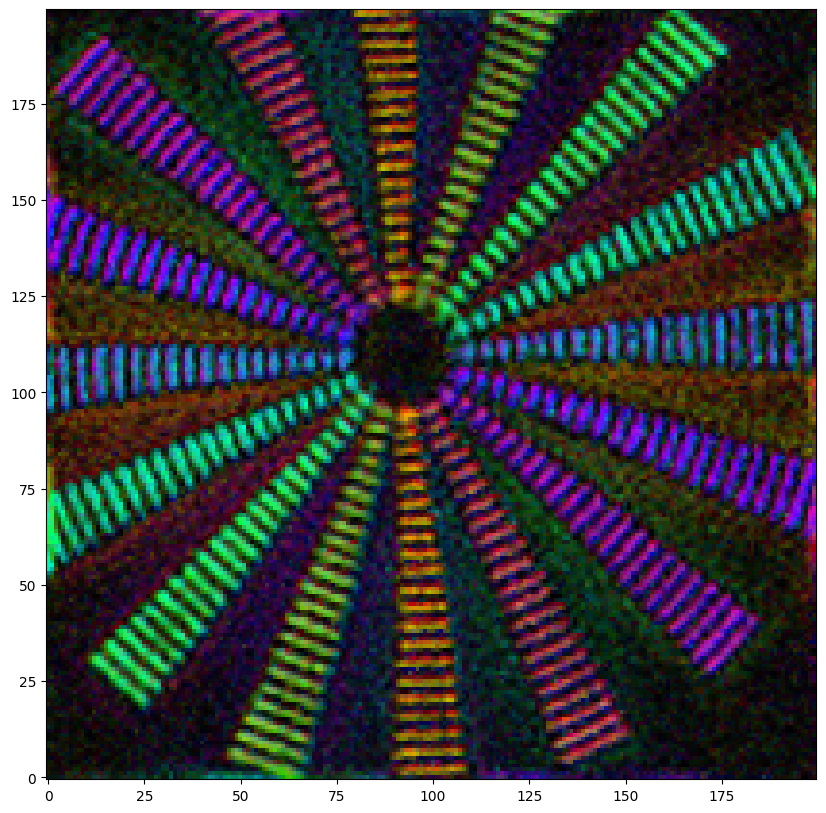

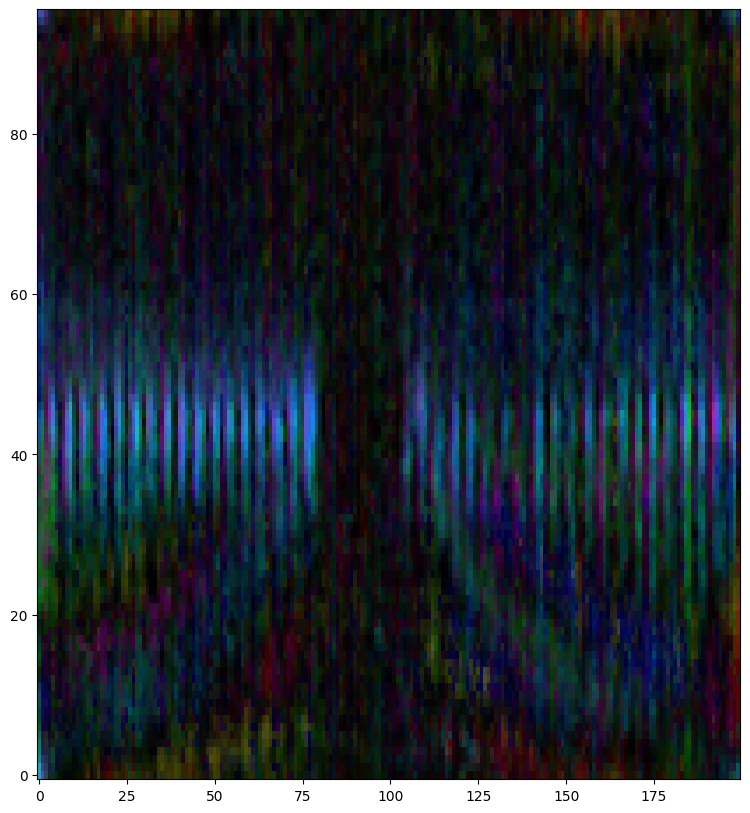

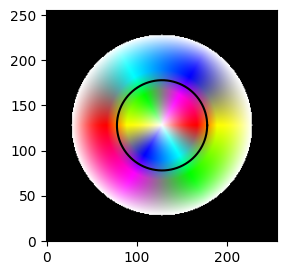

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(orientation_3D_image_RGB[z_layer], origin='lower')
plt.figure(figsize=(10,10))
plt.imshow(orientation_3D_image_RGB[:,y_layer], origin='lower',aspect=z_step/ps)

# plot the top view of 3D orientation colorsphere
plt.figure(figsize=(3,3))
visual.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

### Render 3D orientation with 2 channels (in-plane orientation and out-of-plane tilt)

In [39]:
# in-plane orientation
from matplotlib.colors import hsv_to_rgb

I_hsv = np.transpose(np.array([(azimuth[1])%np.pi/np.pi, \
                               np.ones_like(retardance_pr_PT[1]), \
                               (np.clip(np.abs(retardance_pr_PT[1]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (3,1,2,0))
in_plane_orientation = hsv_to_rgb(I_hsv.copy())

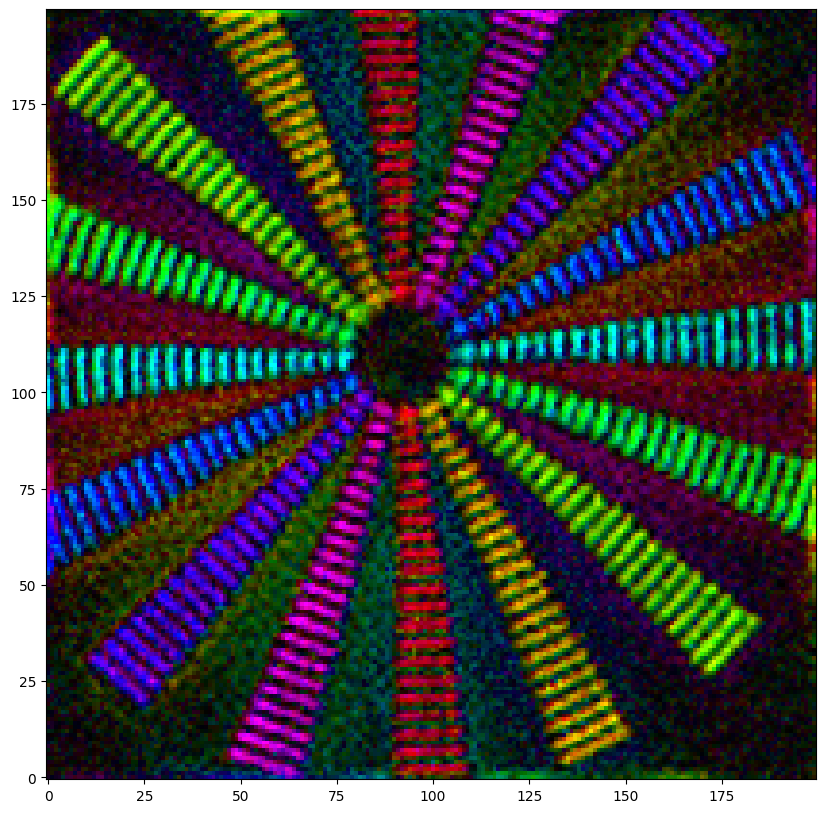

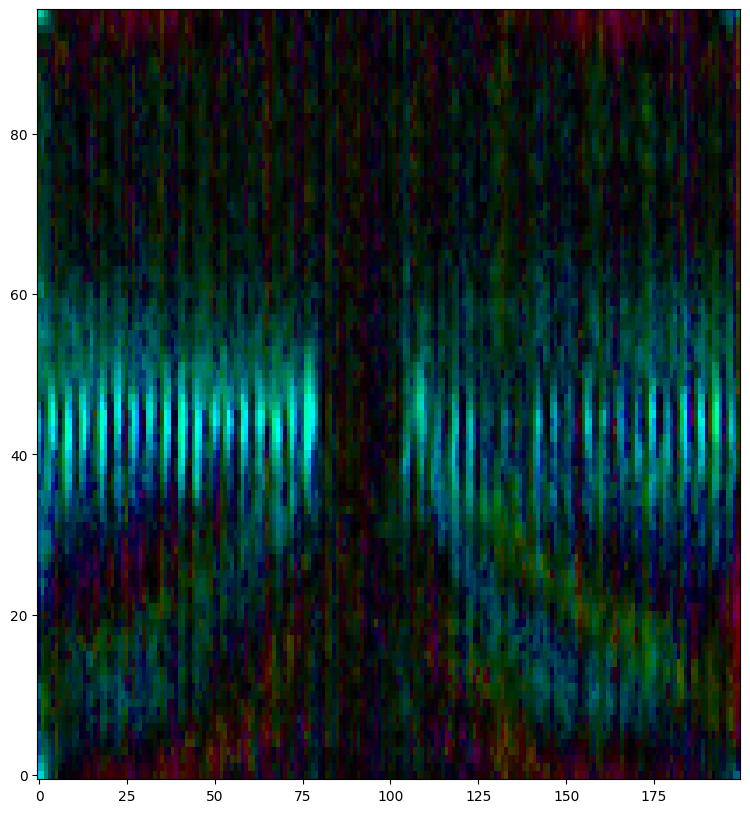

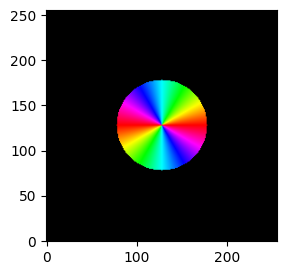

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(in_plane_orientation[z_layer], origin='lower')
plt.figure(figsize=(10,10))
plt.imshow(in_plane_orientation[:,y_layer], origin='lower',aspect=z_step/ps)
plt.figure(figsize=(3,3))
visual.orientation_2D_colorwheel()

In [41]:
# out-of-plane tilt

threshold_inc = np.pi/90

I_hsv = np.transpose(np.array([(-np.maximum(0,np.abs(theta[1]-np.pi/2)-threshold_inc)+np.pi/2+threshold_inc)/np.pi, \
                               np.ones_like(retardance_pr_PT[1]), \
                               (np.clip(np.abs(retardance_pr_PT[1]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (3,1,2,0))
out_of_plane_tilt = hsv_to_rgb(I_hsv.copy())

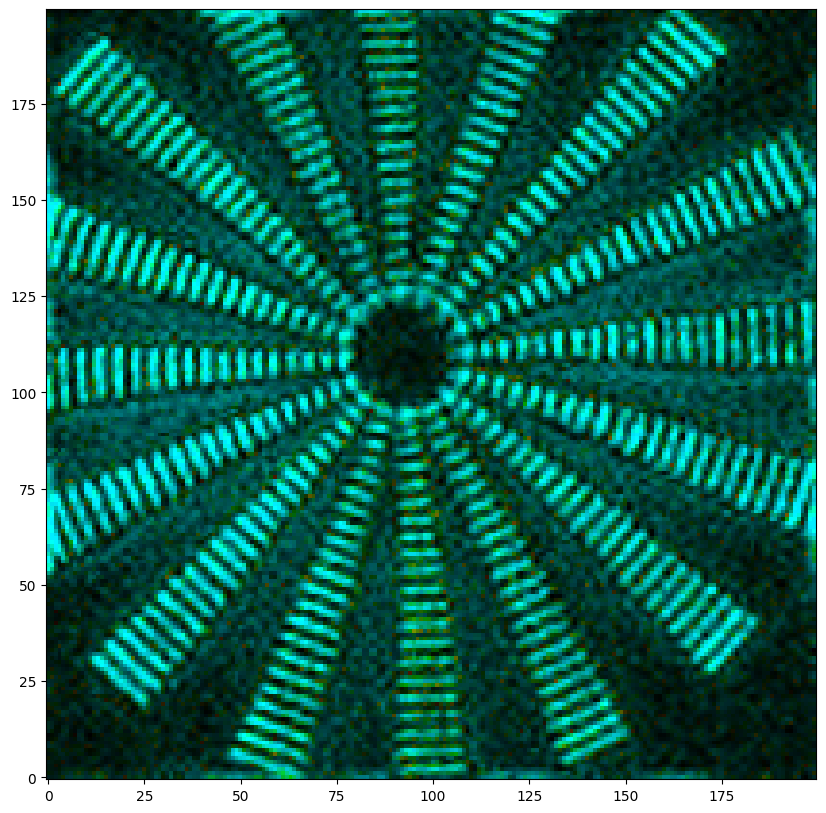

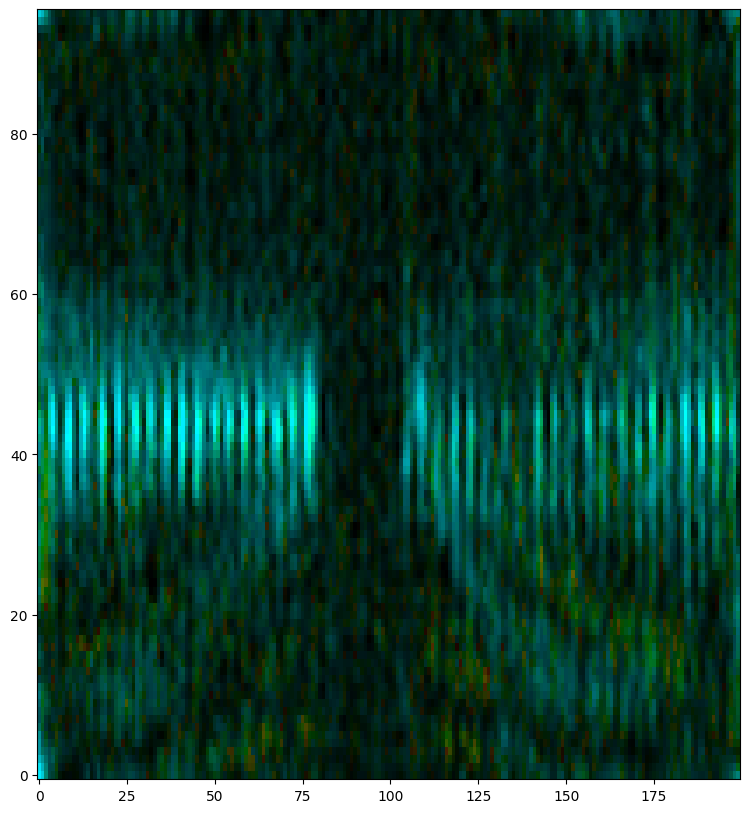

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(out_of_plane_tilt[z_layer], origin='lower')
plt.figure(figsize=(10,10))
plt.imshow(out_of_plane_tilt[:,y_layer], origin='lower',aspect=z_step/ps)

### Angular histogram of computed 3D orientation

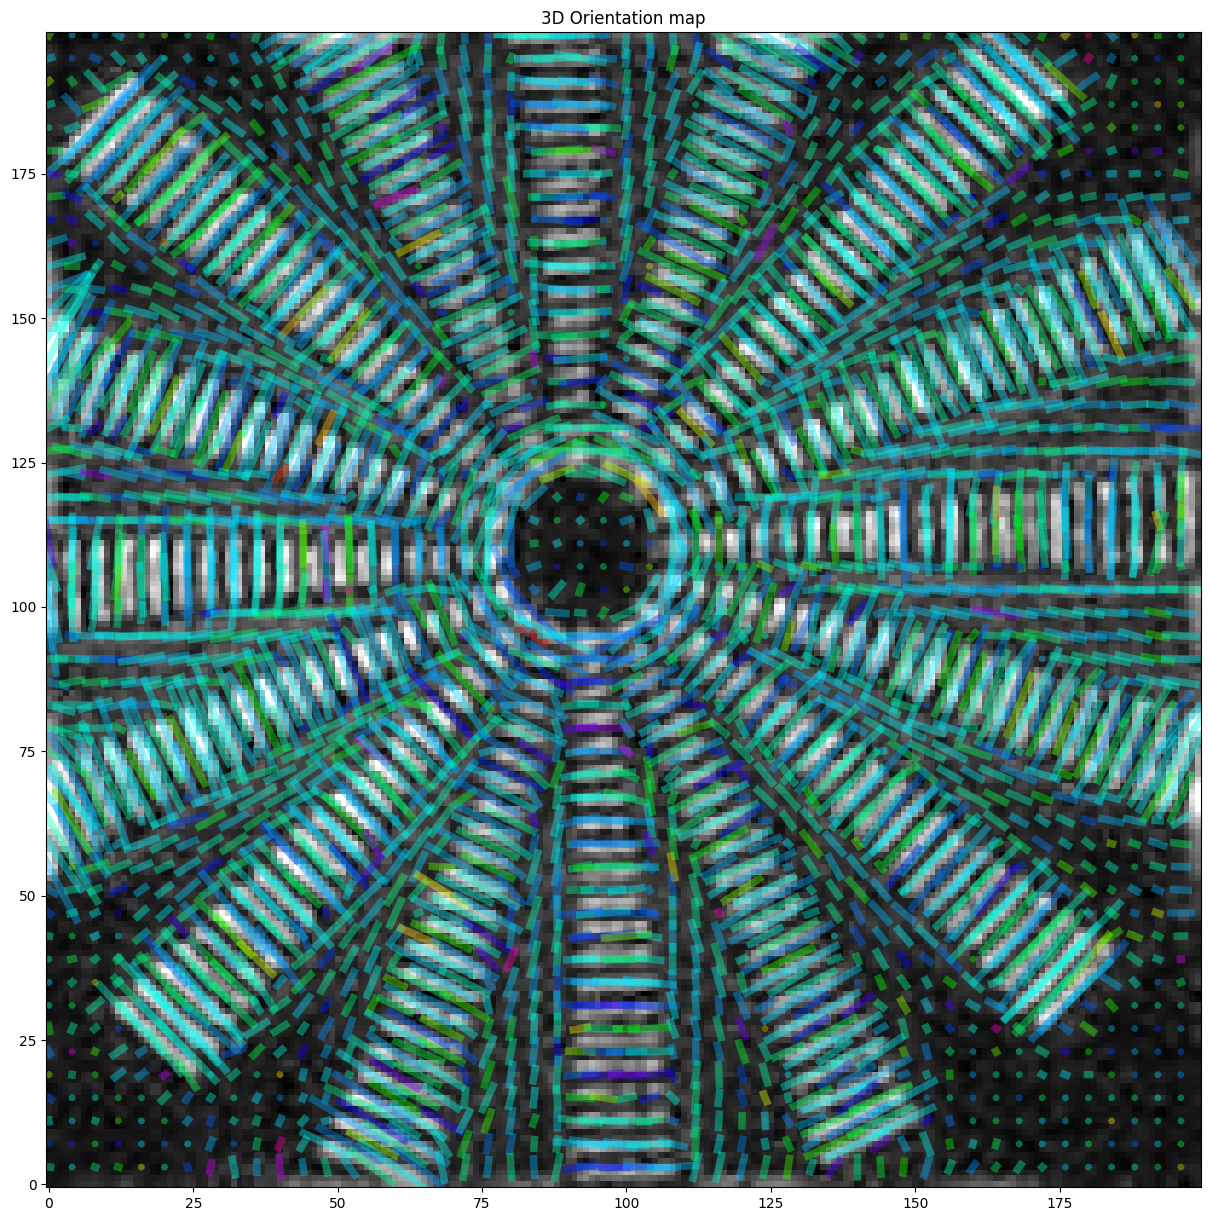

In [43]:
spacing = 4
z_layer =  44


fig,ax = plt.subplots(1,1,figsize=(15,15))

visual.plot3DVectorField(np.abs(retardance_pr_PT[1,:,:,z_layer]), azimuth[1,:,:,z_layer], theta[1,:,:,z_layer], 
                     anisotropy=40*np.abs(retardance_pr_PT[1,:,:,z_layer]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=spacing, linelength=spacing*1.8, linewidth=1.3, cmapAzimuth='hsv', alpha=0.4)





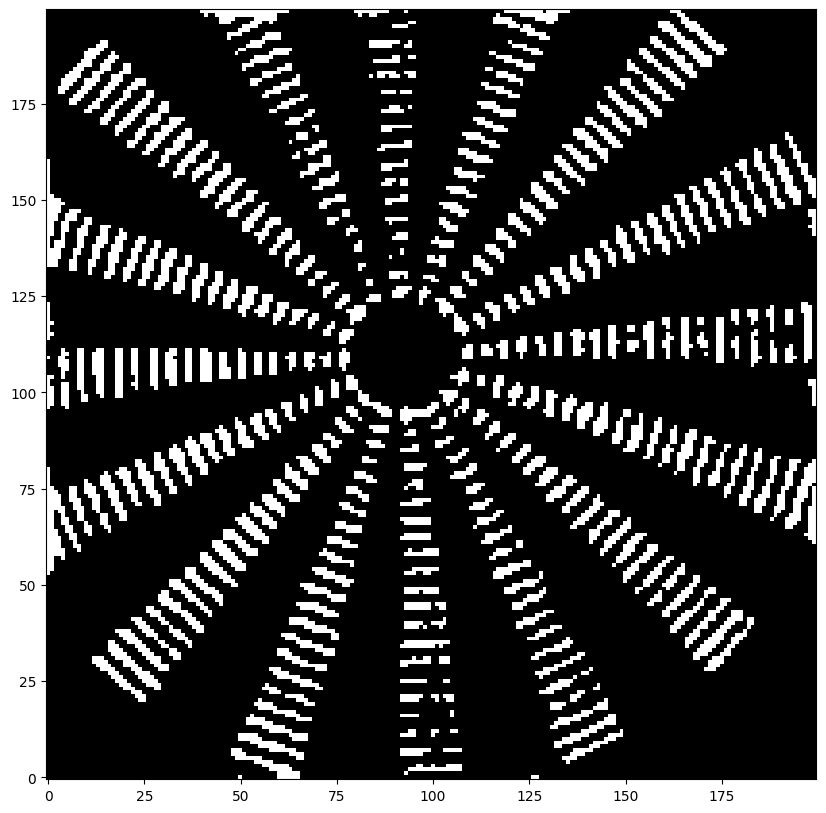

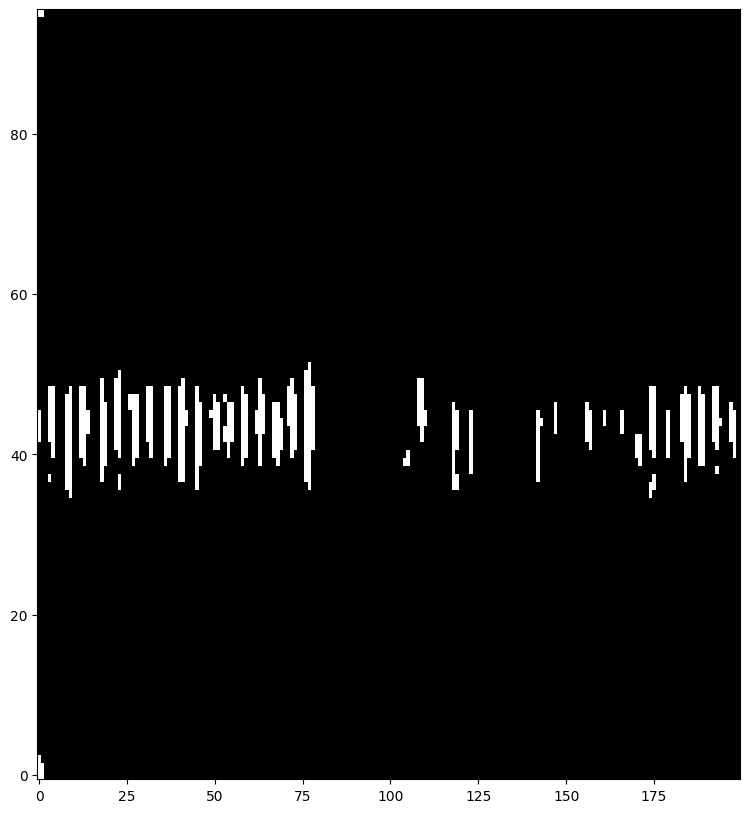

In [44]:
ret_mask = np.abs(retardance_pr_PT[1]).copy()
ret_mask[ret_mask<0.0075]=0
ret_mask[ret_mask>0.0075]=1


plt.figure(figsize=(10,10))
plt.imshow(ret_mask[:,:,z_layer], cmap='gray', origin='lower')
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(ret_mask[y_layer,:,:]), cmap='gray', origin='lower', aspect=z_step/ps)


(<Figure size 1000x1000 with 2 Axes>, <PolarAxes: >)

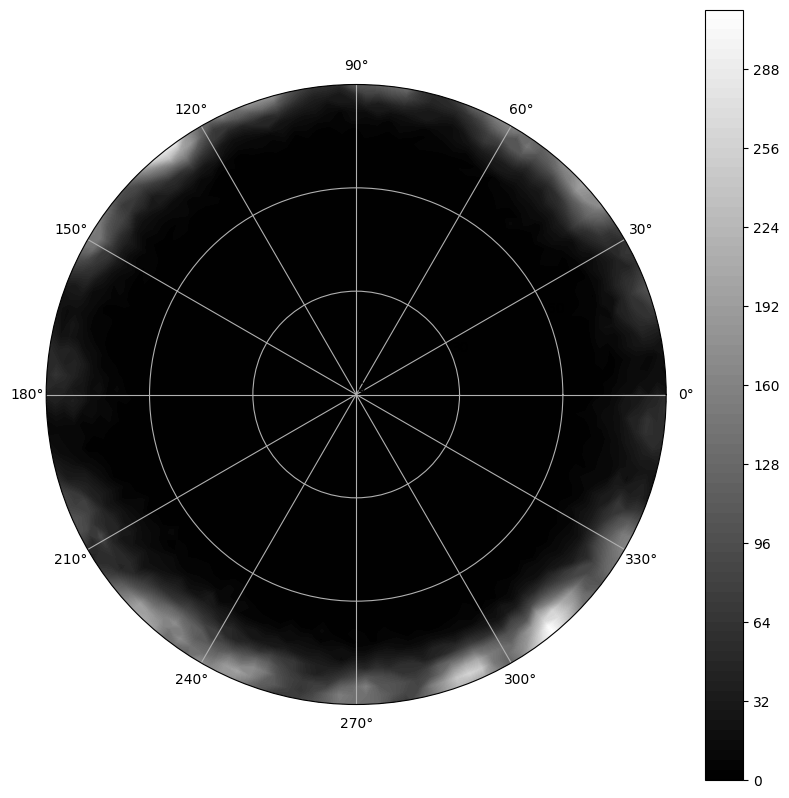

In [45]:
# Angular histogram of 3D orientation 

visual.orientation_3D_hist(azimuth[1].flatten(), \
                       theta[1].flatten(), \
                       ret_mask.flatten(),\
                       bins=72, num_col=1, size=10, contour_level = 100, hist_cmap='gray', top_hemi=True)